In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from Preprocessing.to_embedding import WordEmbedding
from Preprocessing.data_format import formatting
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
data = formatting("phase1_movie_reviews-train.csv")
data = data[:round(len(data)*0.5)]
y = data[['polarity']]

embedding_size = 150 #number of feature weights in embeddings

In [3]:
embedding = WordEmbedding(num_features = embedding_size)
WordEmbedding.fit(embedding, data['reviewText'])

In [4]:
WordEmbedding.size(embedding)

Total number of words in the vocabulary:  (41186, 150)


In [5]:
#Save word embedding to dataframe
#train_embeddings = WordEmbedding.to_pd(embedding, data['reviewText'])

#Save Save embeddings to file
WordEmbedding.to_file(embedding)

## 1. Extract training Word2vec Embeddings from file

In [6]:
embeddings_index = {}
f = open(os.path.join('', 'trained_embedding_word2vec.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close

<function TextIOWrapper.close()>

## 2. Vectorize text data

In [7]:
#Basic Vectorization of data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['reviewText'])
sequences = tokenizer.texts_to_sequences(data['reviewText'])

#pad sequences
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

max_length = int(round(np.mean([len(s) for s in data['reviewText'].values])))
review_pad = pad_sequences(sequences, maxlen = max_length)
sentiment = data['polarity'].values
print('Shape of review tensor', review_pad.shape)
print('Shape of sentiment tensor', sentiment.shape)

Found 137689 unique tokens.
Shape of review tensor (45000, 221)
Shape of sentiment tensor (45000,)


## 3. Create word vectors with the loaded word2vec model

In [8]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_size))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector 

## 4. Shaping train/dev data

In [9]:
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
sentiment = sentiment[indices]
num_val_samples = int(0.2 * review_pad.shape[0])

sentiment = pd.get_dummies(sentiment)

X_train = review_pad[:-num_val_samples]
y_train = sentiment[:-num_val_samples]
X_test = review_pad[-num_val_samples:]
y_test = sentiment[-num_val_samples:]

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of X_test:', X_test.shape)

Shape of X_train: (36000, 221)
Shape of y_train: (36000, 2)
Shape of X_test: (9000, 221)
Shape of X_test: (9000, 221)


In [6]:
data = data[['year']]
data = pd.concat([data, train_embeddings], axis=1, sort=False)

y = pd.get_dummies(y)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.20, random_state = 42)

In [10]:
X_train.shape

(36000, 221)

## 5. Define model

In [86]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

# Define Model
model = Sequential()
embedding_layer = Embedding(num_words,
                            embedding_size,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_length,
                            trainable = False)

model.add(embedding_layer)
model.add(GRU(units = 32, dropout = 0.2 , recurrent_dropout = 0.2))
model.add(Dense(2, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

## 5. Define model plus version

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

# Define Model

embedding_review = Embedding(num_words,
                            embedding_size,
                            embeddings_initializer = Constant(embedding_matrix),
                            input_length = max_length,
                            trainable = False)

model.add(embedding_layer)
model.add(GRU(units = 32, dropout = 0.2 , recurrent_dropout = 0.2))
model.add(Dense(2, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [91]:
history = model.fit(X_train, y_train, batch_size = 2056, epochs = 40, validation_data = (X_test, y_test), verbose = 1)

Train on 36000 samples, validate on 9000 samples
Epoch 1/40
36000/36000 [==============================] - 27s 751us/step - loss: 0.2285 - acc: 0.9093 - val_loss: 0.2349 - val_acc: 0.9141
Epoch 2/40
36000/36000 [==============================] - 27s 743us/step - loss: 0.2278 - acc: 0.9111 - val_loss: 0.2319 - val_acc: 0.9149
Epoch 3/40
36000/36000 [==============================] - 27s 743us/step - loss: 0.2247 - acc: 0.9119 - val_loss: 0.2343 - val_acc: 0.9154
Epoch 4/40
36000/36000 [==============================] - 26s 736us/step - loss: 0.2250 - acc: 0.9111 - val_loss: 0.2250 - val_acc: 0.9172
Epoch 5/40
36000/36000 [==============================] - 27s 740us/step - loss: 0.2189 - acc: 0.9135 - val_loss: 0.2246 - val_acc: 0.9177
Epoch 6/40
36000/36000 [==============================] - 26s 736us/step - loss: 0.2193 - acc: 0.9135 - val_loss: 0.2227 - val_acc: 0.9181
Epoch 7/40
36000/36000 [==============================] - 27s 736us/step - loss: 0.2156 - acc: 0.9154 - val_loss: 0.2

In [92]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Development Accuracy:  0.9444
Testing Accuracy:  0.9236


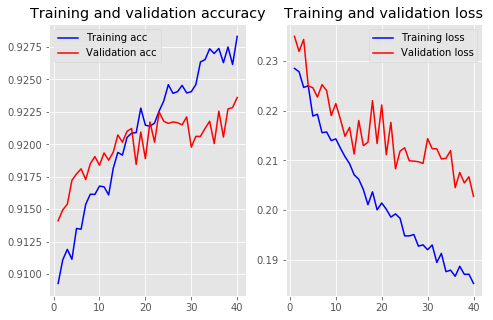

In [93]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Development Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)